## Policy measures analysis
In this notebook multiple policies can be tested, based on a chosen problem formulations. The effects on deaths and costs are summerized at the end of the notebook.

### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8.2


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [4]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [5]:
used_problem_formulation = 2

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [6]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [7]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [8]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'), function=<function sum_over at 0x0000021A7854E820>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

### Policy formulations
In the following cells the wanted policies can be adjusted

In [9]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [10]:
pol_list = []
pol_list.append(create_policy({}, name="Zero"))

for meter in [5, 10]:
    pol_list.append(create_policy({"A.3_DikeIncrease 0": meter}, name=f"Dike_A.3_{meter}"))
    
for location in [2, 3, 4]:
    for ews_days in [0, 4]:
        pol_list.append(create_policy({f"{location}_RfR 0": 1, "EWS_DaysToThreat": ews_days}, name=f"RfR_{location}_EWS_{ews_days}_days"))


### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [11]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = False

if use_pickle1:
    with open('data/formulation_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 5
    with MultiprocessingEvaluator(dike_model, n_processes=7) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/formulation_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 5 scenarios * 9 policies * 1 model(s) = 45 experiments
  2%|▉                                          | 1/45 [00:07<05:14,  7.14s/it]Traceback (most recent call last):
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 244, in _store_outcomes
    self.results[outcome][case_id,] = outcome_res
KeyError: 'Dike Investment Costs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\ema_multiprocessing.py", line 253, in run
    self.callback(*result.get())
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 279, in __call__
    self._store_outcomes(experiment.experiment_id, outcomes)
  File "C:\Users\Ewout\miniconda3\lib\site-packages\ema_workbench\em_framework\callbacks.py", line 258, in _sto

### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [12]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["policy"] = pd.DataFrame(exp)["policy"]
df

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,policy
0,3.310547e+09,0,NaN,NaN,NaN,Policy_Zero
1,4.951533e+08,0,0.0,0.000000,0.262093,Policy_Zero
2,1.884253e+09,0,0.0,0.000000,3.736003,Policy_Zero
3,3.160493e+09,0,0.0,0.000000,2.046292,Policy_Zero
4,9.576766e+08,0,0.0,0.000000,1.415537,Policy_Zero
5,3.310547e+09,28798397,0.0,0.000000,2.784966,Policy_Dike_A.3_5
6,4.951533e+08,28798397,0.0,0.000000,0.262093,Policy_Dike_A.3_5
7,8.521325e+07,28798397,0.0,0.000000,0.142109,Policy_Dike_A.3_5
8,3.160493e+09,28798397,0.0,0.000000,2.046292,Policy_Dike_A.3_5
9,1.627937e+08,28798397,0.0,0.000000,0.113812,Policy_Dike_A.3_5


In [13]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [15]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "Expected Annual Damage": agg_par,
    "Expected Number of Deaths": agg_par,
}
# Create new dataframe with the aggegrated data per policy
TCA_df = group_df.agg(agg_dict)
TCA_df

Expected Annual Damage                              \
                                          mean           min           max   
policy                                                                       
Policy_Dike_A.3_10                1.432482e+09  3.342408e+07  3.310547e+09   
Policy_Dike_A.3_5                 1.442840e+09  8.521325e+07  3.310547e+09   
Policy_RfR_2_EWS_0_days           1.641008e+09  3.803834e+08  3.160493e+09   
Policy_RfR_2_EWS_4_days           1.641008e+09  3.803834e+08  3.160493e+09   
Policy_RfR_3_EWS_0_days           1.851324e+09  3.992967e+08  3.308141e+09   
Policy_RfR_3_EWS_4_days           1.851324e+09  3.992967e+08  3.308141e+09   
Policy_RfR_4_EWS_0_days           1.947653e+09  4.512605e+08  3.310547e+09   
Policy_RfR_4_EWS_4_days           1.947653e+09  4.512605e+08  3.310547e+09   
Policy_Zero                       1.961625e+09  4.951533e+08  3.310547e+09   

                                                    Expected Number of Deaths  \
                                  q05           q95                      mean   
policy                                                                          
Policy_Dike_A.3_10       5.929800e+07  3.280536e+09                  1.047232   
Policy_Dike_A.3_5        1.007293e+08  3.280536e+09                  1.069854   
Policy_RfR_2_EWS_0_days  4.033082e+08  3.145760e+09                  1.493381   
Policy_RfR_2_EWS_4_days  4.033082e+08  3.145760e+09                  0.179206   
Policy_RfR_3_EWS_0_days  4.511066e+08  3.278612e+09                  1.881217   
Policy_RfR_3_EWS_4_days  4.511066e+08  3.278612e+09                  0.225746   
Policy_RfR_4_EWS_0_days  5.493338e+08  3.280536e+09                  2.036497   
Policy_RfR_4_EWS_4_days  5.493338e+08  3.280536e+09                  0.244380   
Policy_Zero              5.876579e+08  3.280536e+09                  1.864982   

                                                                 
                              min       max       q05       q95  
policy                                                           
Policy_Dike_A.3_10       0.028996  2.784966  0.045959  2.637231  
Policy_Dike_A.3_5        0.113812  2.784966  0.119471  2.637231  
Policy_RfR_2_EWS_0_days  0.261859  2.563934  0.306546  2.473052  
Policy_RfR_2_EWS_4_days  0.031423  0.307672  0.036786  0.296766  
Policy_RfR_3_EWS_0_days  0.209541  3.403930  0.360635  3.279407  
Policy_RfR_3_EWS_4_days  0.025145  0.408472  0.043276  0.393529  
Policy_RfR_4_EWS_0_days  0.247290  3.705768  0.477466  3.521608  
Policy_RfR_4_EWS_4_days  0.029675  0.444692  0.057296  0.422593  
Policy_Zero              0.262093  3.736003  0.435110  3.482547

### PLots

<AxesSubplot:xlabel='policy'>

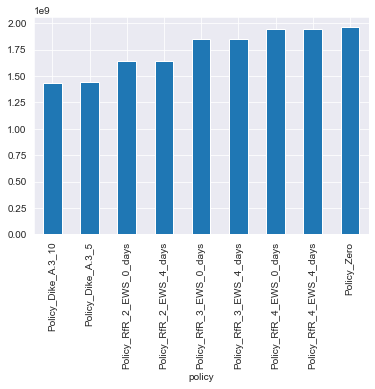

In [17]:
TCA_df["Expected Annual Damage"]["mean"].plot.bar()

<AxesSubplot:xlabel='policy'>

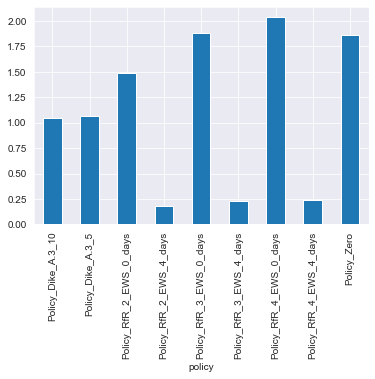

In [18]:
TCA_df["Expected Number of Deaths"]["mean"].plot.bar()

In [ ]:
# Save the aggegrated data to a CSV file
#TCA_df.to_csv("results/TCA3_results.csv")